In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import random
import time
from pathlib import Path

import re
from IPython import display


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))


there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [4]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))


the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


# Dataset

In [5]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))


There are 7370 image in training data


In [6]:
df.head(5)


,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [ ]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):
    # load in the image according to image path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32)
    # data augmentation
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_brightness(img, max_delta=0.04)
    img = tf.image.resize(img, size=[IMAGE_HEIGHT + IMAGE_HEIGHT // 10, IMAGE_WIDTH + IMAGE_WIDTH // 10])
    img = tf.image.random_crop(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = (img / 255) * 2 - 1
    caption = tf.cast(caption, tf.int32)

    return img, caption

def dataset_generator(filenames, batch_size, data_generator, num_rows=None):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    if num_rows is not None:
        df = df.head(num_rows)
    captions = df['Captions'].values
    image_paths = df['ImagePath'].values

    caption = []
    image_path = []
    # each image has 1 to 10 corresponding captions
    # we choose all of them randomly for training
    for idx in range(len(captions)):
        for cap in captions[idx]:
            caption.append(cap)
            image_path.append(image_paths[idx])
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    image_path = np.asarray(image_path)

    # assume that each row of `features` corresponds to the same row as `labels`.
    assert caption.shape[0] == image_path.shape[0]
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset


In [ ]:
random.seed(0)
tf.random.set_seed(0)
BATCH_SIZE = 1
dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE, training_data_generator, num_rows=100)

(None, None, 3)


C:\Users\pony\AppData\Local\Temp\ipykernel_6276\1213281132.py:62: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  caption = caption.astype(np.int)


Num steps: 941
(1,1): [   9    2   17    9    1    6   14   13   18    7   84   10    6   32
   14   13   18 5427 5427 5427]


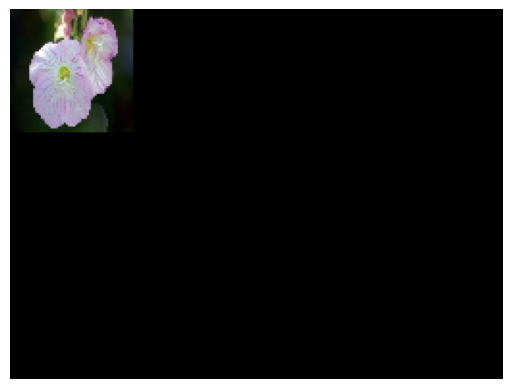

In [9]:
import imageio

SAMPLE_ROW = 3
SAMPLE_COL = 4
SAMPLE_NUM = SAMPLE_ROW * SAMPLE_COL

def generate_img(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), dtype=np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None: 
        imageio.imwrite(path, out)
    return out

num_steps = len(dataset)
print(f'Num steps: {num_steps}')

imgs, caps = next(iter(dataset))

# Show caption
caps = caps[:SAMPLE_NUM].numpy()
for idx, cap in enumerate(caps):
    i, j = divmod(idx, SAMPLE_COL)
    print(f'({i+1},{j+1}): {cap}')
    
# Show image
imgs = tf.clip_by_value((imgs[:SAMPLE_NUM] + 1) / 2 * 255, 0, 255)
img = generate_img(imgs, SAMPLE_ROW, SAMPLE_COL)
plt.imshow(img)
plt.axis("off")
plt.show()